In [ ]:
import pandas as pd
from gurobipy import Model, GRB, quicksum

# --- Synthetic Request Data (Updated) ---
requests_data = [
    {"RequestID": "R1", "TokenCount": 400, "LatencyRequirement": 350, "BudgetThreshold": 0.02, "Complexity": 2},
    {"RequestID": "R2", "TokenCount": 600, "LatencyRequirement": 450, "BudgetThreshold": 0.02, "Complexity": 4},
    {"RequestID": "R3", "TokenCount": 900, "LatencyRequirement": 600, "BudgetThreshold": 0.05, "Complexity": 6},
    {"RequestID": "R4", "TokenCount": 1200, "LatencyRequirement": 1000, "BudgetThreshold": 0.08, "Complexity": 9},
    {"RequestID": "R5", "TokenCount": 700, "LatencyRequirement": 400, "BudgetThreshold": 0.015, "Complexity": 3},
    {"RequestID": "R6", "TokenCount": 1100, "LatencyRequirement": 650, "BudgetThreshold": 0.04, "Complexity": 7},
    {"RequestID": "R7", "TokenCount": 500, "LatencyRequirement": 350, "BudgetThreshold": 0.018, "Complexity": 5},
    {"RequestID": "R8", "TokenCount": 1300, "LatencyRequirement": 1000, "BudgetThreshold": 0.09, "Complexity": 10}
]
requests_df = pd.DataFrame(requests_data)
n_requests = len(requests_df)

# --- Backend Definitions ---
backends = {
    "GPT-4":   {"latency": 800, "capacity": 5000, "cost": 0.06, "min_complexity": 8, "max_complexity": float('inf')},
    "GPT-3.5": {"latency": 500, "capacity": 7000, "cost": 0.03, "min_complexity": 4, "max_complexity": 7},
    "Turbo":   {"latency": 300, "capacity": 10000, "cost": 0.01, "min_complexity": 0, "max_complexity": 3}
}
backend_names = list(backends.keys())

# --- Initialize Gurobi Model ---
model = Model("Request_Routing_Always_Assign")
model.setParam('OutputFlag', 1)

# --- Decision Variables: Based only on complexity bands ---
x = {}
for i in range(n_requests):
    complexity = requests_df.loc[i, "Complexity"]
    for j in backend_names:
        if backends[j]["min_complexity"] <= complexity <= backends[j]["max_complexity"]:
            x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

# --- Assignment Constraints: One backend per request ---
for i in range(n_requests):
    feasible = [j for j in backend_names if (i, j) in x]
    model.addConstr(quicksum(x[i, j] for j in feasible) == 1, name=f"Assign_{i}")

# --- Capacity Constraints ---
for j in backend_names:
    model.addConstr(
        quicksum(requests_df.loc[i, "TokenCount"] * x[i, j]
                 for i in range(n_requests) if (i, j) in x) <= backends[j]["capacity"],
        name=f"Capacity_{j}"
    )

# --- Objective: Minimize total cost only ---
model.setObjective(
    quicksum(x[i, j] * backends[j]["cost"] * requests_df.loc[i, "TokenCount"] / 1000 for (i, j) in x),
    GRB.MINIMIZE
)

# --- Solve ---
model.optimize()

# --- Output Results ---
assignments = []
if model.status == GRB.OPTIMAL:
    print("\n✅ Optimization successful!\n")
    for i in range(n_requests):
        for j in backend_names:
            if (i, j) in x and x[i, j].X > 0.5:
                tokens = requests_df.loc[i, "TokenCount"]
                latency = backends[j]["latency"]
                budget = requests_df.loc[i, "BudgetThreshold"]
                latency_req = requests_df.loc[i, "LatencyRequirement"]
                cost = round(backends[j]["cost"] * tokens / 1000, 4)
                meets_latency = latency <= latency_req
                meets_budget = cost <= budget

                assignments.append({
                    "RequestID": requests_df.loc[i, "RequestID"],
                    "Backend": j,
                    "TokenCount": tokens,
                    "Cost": cost,
                    "LatencyLimit": latency_req,
                    "ActualLatency": latency,
                    "Budget": budget,
                    "MeetsLatency": meets_latency,
                    "MeetsBudget": meets_budget
                })

                print(f"🔹 Request {requests_df.loc[i, 'RequestID']} → {j} | Tokens: {tokens}, "
                      f"Cost: ${cost}, Latency OK: {meets_latency}, Budget OK: {meets_budget}")

    pd.DataFrame(assignments).to_csv("final_assignments.csv", index=False)
    print("\n💾 Saved to 'final_assignments.csv'")
else:
    print("❌ Optimization failed. Status:", model.status)

Restricted license - for non-production use only - expires 2026-11-23
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11 rows, 8 columns and 16 nonzeros
Model fingerprint: 0x94cab407
Variable types: 0 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [4e-03, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 0.2540000
Presolve removed 11 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0.254 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.540000000000e-01, best bound 2.540000000000e-01, gap 0.000

/var/folders/77/vrz1k_rd4hbdc6hhb0vglq1r0000gn/T/ipykernel_89868/4140406605.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=assignments_df, x='Backend', palette='Set2')


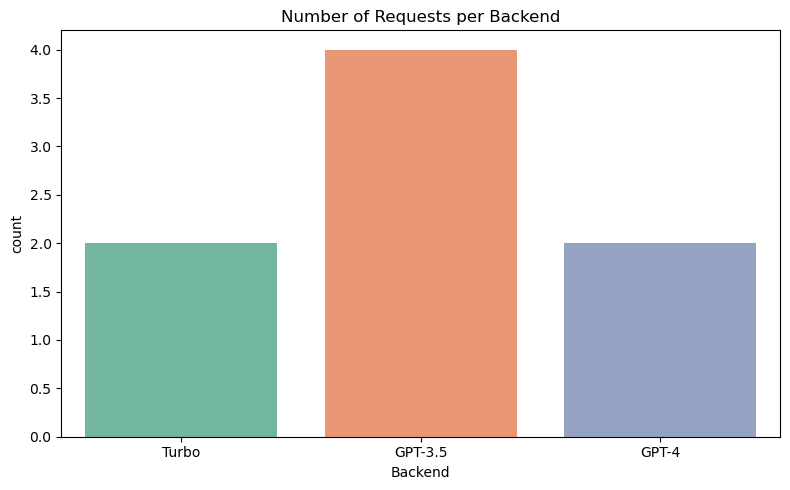

/var/folders/77/vrz1k_rd4hbdc6hhb0vglq1r0000gn/T/ipykernel_89868/4140406605.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=assignments_df, x='Backend', y='Cost', estimator=sum, ci=None, palette='Set3')
/var/folders/77/vrz1k_rd4hbdc6hhb0vglq1r0000gn/T/ipykernel_89868/4140406605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=assignments_df, x='Backend', y='Cost', estimator=sum, ci=None, palette='Set3')


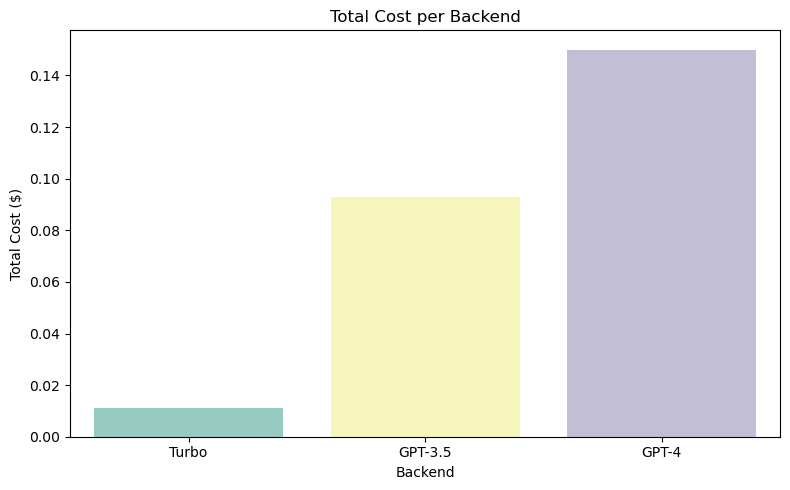

/var/folders/77/vrz1k_rd4hbdc6hhb0vglq1r0000gn/T/ipykernel_89868/4140406605.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=latency_rate, x='Backend', y='MeetsLatency', palette='Blues_d')


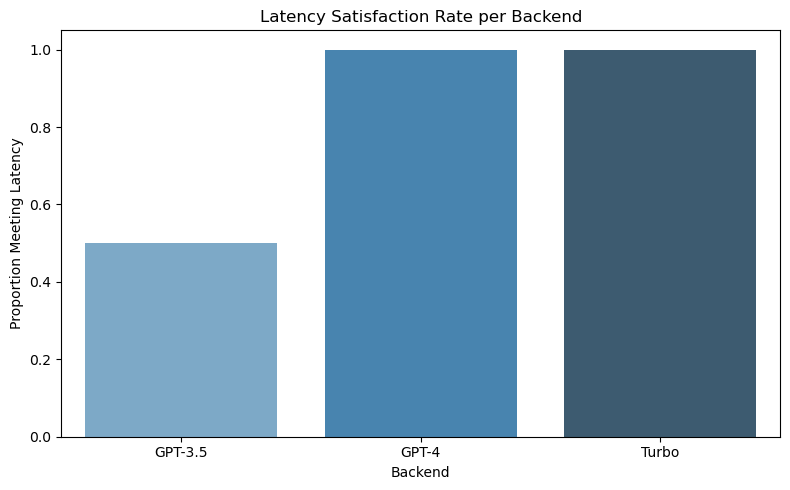

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Visualization Section ---
assignments_df = pd.DataFrame(assignments)

# Requests per Backend
plt.figure(figsize=(8, 5))
sns.countplot(data=assignments_df, x='Backend', palette='Set2')
plt.title("Number of Requests per Backend")
plt.tight_layout()
plt.show();

# Total Cost per Backend
plt.figure(figsize=(8, 5))
sns.barplot(data=assignments_df, x='Backend', y='Cost', estimator=sum, ci=None, palette='Set3')
plt.title("Total Cost per Backend")
plt.ylabel("Total Cost ($)")
plt.tight_layout()
plt.show();

# Latency Satisfaction Rate per Backend
latency_rate = assignments_df.groupby("Backend")["MeetsLatency"].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=latency_rate, x='Backend', y='MeetsLatency', palette='Blues_d')
plt.title("Latency Satisfaction Rate per Backend")
plt.ylabel("Proportion Meeting Latency")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show();